# Imports

In [1]:
import chess
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
import random
import keras
from keras.layers import Input
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# CNN Model that knows the checkmate position

In [2]:
# Function to create the model
def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(8, 8, 17)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Flatten(),
        Dense(200, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='tanh')
    ])
    return model


# Read the data from csv file and make ready to feed to neural network

In [3]:
df =pd.read_csv("1-200000_game.csv")

def process_position(pos_string):
    try:
        # Remove outer brackets and split the string into rows
        rows = pos_string.strip('[]').split('],[')

        # Initialize an empty list to store the processed rows
        processed_rows = []

        # Process each row
        for row in rows:
            # Clean up the row string and split it into elements
            cleaned_row = row.replace('[', '').replace(']', '').strip()
            processed_row = [int(num) for num in cleaned_row.split(',')]

            # Append the processed row to the list
            processed_rows.append(processed_row)

        # Convert the list of lists into a numpy array and reshape it
        board_array = np.array(processed_rows)
        board_array_reshaped = board_array.reshape(1, 8, 8, 17)
        return board_array_reshaped
    except Exception as e:
        # Print the error and return None or a default value
        print(f"Error processing position: {e}")
        return None


# Process positions and extract labels
df['processed_positions'] = df['0'].apply(process_position)
X = np.array(df['processed_positions'].tolist())
y = df['2'].values

In [4]:
X = np.squeeze(X, axis=1)
print(X.shape)

(61444, 8, 8, 17)


In [5]:
len(X)

61444

# Training of Model

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
model = create_model()

# Adjusted learning rate
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Epoch 1/20
615/615 [==============================] - 16s 26ms/step - loss: 0.1408 - val_loss: 0.1003
Epoch 2/20
615/615 [==============================] - 16s 27ms/step - loss: 0.0810 - val_loss: 0.0620
Epoch 3/20
615/615 [==============================] - 17s 28ms/step - loss: 0.0613 - val_loss: 0.0571
Epoch 4/20
615/615 [==============================] - 17s 27ms/step - loss: 0.0490 - val_loss: 0.0532
Epoch 5/20
615/615 [==============================] - 18s 28ms/step - loss: 0.0457 - val_loss: 0.0488
Epoch 6/20
615/615 [==============================] - 18s 29ms/step - loss: 0.0402 - val_loss: 0.0477
Epoch 7/20
615/615 [==============================] - 17s 27ms/step - loss: 0.0364 - val_loss: 0.0418
Epoch 8/20
615/615 [==============================] - 17s 28ms/step - loss: 0.0337 - val_loss: 0.0434
Epoch 9/20
615/615 [==============================] - 16s 26ms/step - loss: 0.0312 - val_loss: 0.0420
Epoch 10/20
615/615 [==============================] - 16s 27ms/step - loss: 0.029

# Evaluation Metrics

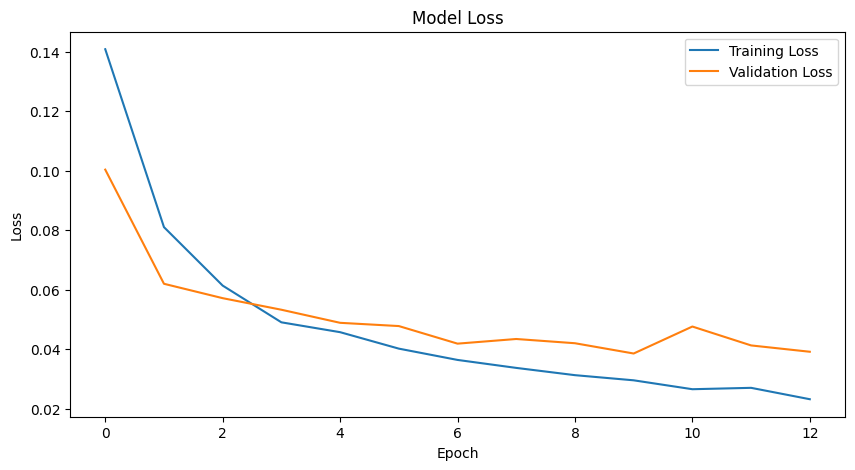

In [28]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [30]:
def board_to_input(board):
    # Define a mapping for pieces to integers
    piece_to_value = {
        (chess.PAWN, chess.WHITE): 1,
        (chess.KNIGHT, chess.WHITE): 2,
        (chess.BISHOP, chess.WHITE): 3,
        (chess.ROOK, chess.WHITE): 4,
        (chess.QUEEN, chess.WHITE): 5,
        (chess.KING, chess.WHITE): 6,
        (chess.PAWN, chess.BLACK): 7,
        (chess.KNIGHT, chess.BLACK): 8,
        (chess.BISHOP, chess.BLACK): 9,
        (chess.ROOK, chess.BLACK): 10,
        (chess.QUEEN, chess.BLACK): 11,
        (chess.KING, chess.BLACK): 12
    }

    # 8x8 grid with 14 channels: 12 for pieces, 1 for castling rights, 1 for side to move
    board_representation = np.zeros((8, 8, 17), dtype=int)

    # Fill the board representation with values for each piece
    for square in chess.SQUARES:
        rank = chess.square_rank(square)
        file = chess.square_file(square)
        piece = board.piece_at(square)
        if piece is not None:
            value = piece_to_value.get((piece.piece_type, piece.color))
            board_representation[rank, file, value - 1] = 1

    # Castling rights and side to move
    castling_rights_white_kingside = int(board.has_kingside_castling_rights(chess.WHITE))
    castling_rights_white_queenside = int(board.has_queenside_castling_rights(chess.WHITE))
    castling_rights_black_kingside = int(board.has_kingside_castling_rights(chess.BLACK))
    castling_rights_black_queenside = int(board.has_queenside_castling_rights(chess.BLACK))
    side_to_move = int(board.turn == chess.WHITE)

    # Add castling rights and side to move to the last two channels uniformly
    board_representation[:, :, 12] = castling_rights_white_kingside
    board_representation[:, :, 13] = castling_rights_white_queenside
    board_representation[:, :, 14] = castling_rights_black_kingside
    board_representation[:, :, 15] = castling_rights_black_queenside

    board_representation[:, :, 16] = side_to_move

    return board_representation

# Applying model to some board postions

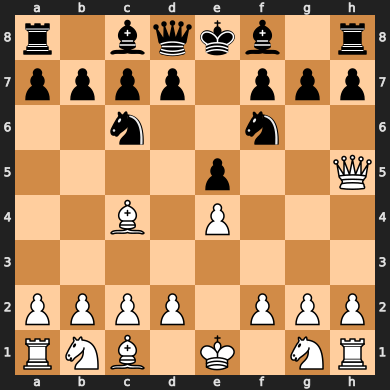

In [31]:
# Load Chessboard Position using FEN Notation
board = chess.Board("r1bqkb1r/pppp1ppp/2n2n2/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 0 1")
board

In [32]:
# Converting Board into multidimentional array
board_input = board_to_input(board)

# Calculating the current value of the current board position.
# value near 0 means non-checkmate position, value more near 1 is white checkmating position, value near -1 is black checkmating position 
score = model.predict(board_input.reshape(1, 8, 8, 17), verbose=0)
score

array([[0.00068083]], dtype=float32)

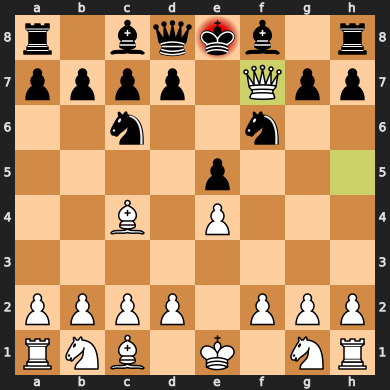

In [33]:
# List to store scores for each possible legal move (just one move ahead)
move_scores = []

# Get List of all legal moves
legal_moves = list(board.legal_moves)
for move in legal_moves:
    board_copy = board.copy()                                           # Make a copy of current board position
    board_copy.push(move)                                               # Make a move on current board-position, now the board has new board position
    board_input = board_to_input(board_copy)                            # Convert the board position into multiimentional array
    score = model.predict(board_input.reshape(1, 8, 8, 17), verbose=0)  # Get the score value of current moved position
    move_scores.append(score)                                           # Save the the score in the list            

if board.turn == chess.WHITE:
    best_move = legal_moves[np.argmax(move_scores)]                     # Choose the move which has highest value if it is white
else:
    best_move = legal_moves[np.argmin(move_scores)]                     # Choose the move which has highest value if it is black
board.push(best_move)                                                   # Make the move
board                                                                   # Current board position

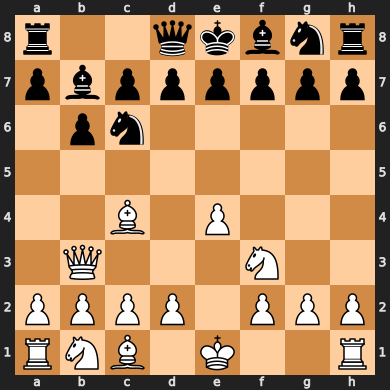

In [34]:
board = chess.Board("r2qkbnr/pbpppppp/1pn5/8/2B1P3/1Q3N2/PPPP1PPP/RNB1K2R w KQkq - 0 1")
board

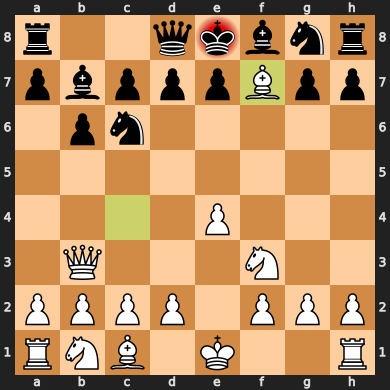

In [35]:
move_scores = []
legal_moves = list(board.legal_moves)
for move in legal_moves:
    board_copy = board.copy()
    board_copy.push(move)
    board_input = board_to_input(board_copy)
    score = model.predict(board_input.reshape(1, 8, 8, 17), verbose=0)
    move_scores.append(score)

if board.turn == chess.WHITE:
    best_move = legal_moves[np.argmax(move_scores)]
else:
    best_move = legal_moves[np.argmin(move_scores)]
board.push(best_move)
board

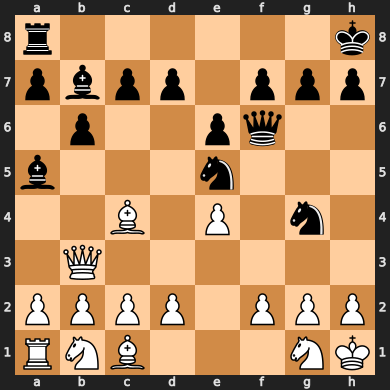

In [36]:
board = chess.Board("r6k/pbpp1ppp/1p2pq2/b3n3/2B1P1n1/1Q6/PPPP1PPP/RNB3NK b Qq - 0 1")
board

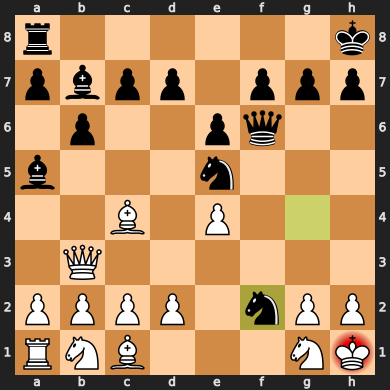

In [37]:
move_scores = []
legal_moves = list(board.legal_moves)
for move in legal_moves:
    board_copy = board.copy()
    board_copy.push(move)
    board_input = board_to_input(board_copy)
    score = model.predict(board_input.reshape(1, 8, 8, 17), verbose=0)
    move_scores.append(score)

if board.turn == chess.WHITE:
    best_move = legal_moves[np.argmax(move_scores)]
else:
    best_move = legal_moves[np.argmin(move_scores)]
board.push(best_move)
board

# Wrong Prediction of Model

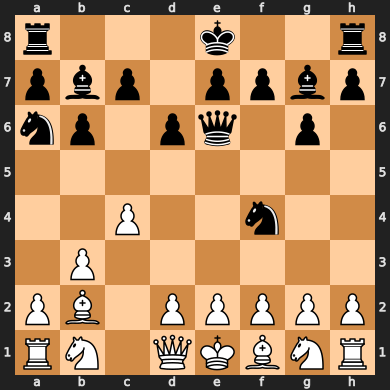

In [38]:
board = chess.Board("r3k2r/pbp1ppbp/np1pq1p1/8/2P2n2/1P6/PB1PPPPP/RN1QKBNR b KQkq - 0 1")
board

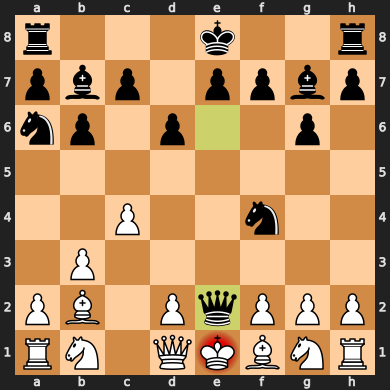

In [39]:
move_scores = []
legal_moves = list(board.legal_moves)
for move in legal_moves:
    board_copy = board.copy()
    board_copy.push(move)
    board_input = board_to_input(board_copy)
    score = model.predict(board_input.reshape(1, 8, 8, 17), verbose=0)
    move_scores.append(score)

if board.turn == chess.WHITE:
    best_move = legal_moves[np.argmax(move_scores)]
else:
    best_move = legal_moves[np.argmin(move_scores)]
board.push(best_move)
board